# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [0]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  4754k      0  0:00:01  0:00:01 --:--:-- 4757k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  2655k      0 --:--:-- --:--:-- --:--:-- 2652k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  6968k      0  0:00:01  0:00:01 --:--:-- 6968k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  2146k      0 --:--:-- --:--:-- --:--:-- 2144k


In [0]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")
ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")

Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [0]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)

test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.seed(42))

num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [0]:
from spotlight.evaluation import mrr_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



0.0


In [0]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 3033.41it/s]

0.0


# Question 1


In [0]:
#Question 1 
from spotlight.evaluation import mrr_score


class average_model:
  
  def __init__(self, ratings_df):
    temp =  ratings_df.groupby('book_id').agg({"rating" : np.mean})
    x = np.zeros(len(temp))
    for i,row in temp.iterrows():
      place = iid_map.get(i)
      x[place] += row['rating']
    
    self.predictions = x
  
  #returns an array of scores, one for each item
  def predict(self, uid):
    return(self.predictions)

print(mrr_score(average_model(ratings_df), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

class n_of_ratings_model:
  
  def __init__(self, books_df):
    temp = books_df[['book_id','ratings_count']]
    x = np.zeros(len(temp))
    for _,row in temp.iterrows():
      place = iid_map.get(row['book_id'])
      x[place] += row['ratings_count']
    self.predictions = x 

  #returns an array of scores, one for each item
  def predict(self, uid):
    return self.predictions

print(mrr_score(n_of_ratings_model(books_df), test_dataset, train=rating_dataset, k=100).mean())

class ratings_of_5_model:
  
  def __init__(self, books_df):
    temp = books_df[['book_id','ratings_5']]
    x = np.zeros(len(temp))
    for _,row in temp.iterrows():
      place = iid_map.get(row['book_id'])
      x[place] += row['ratings_5']
    self.predictions = x 
  #returns an array of scores, one for each item
  def predict(self, uid):
    return(self.predictions)

print(mrr_score(ratings_of_5_model(books_df), test_dataset, train=rating_dataset, k=100).mean())


class fraction_of_5_model:
  
  def __init__(self, books_df):
    temp = books_df[['book_id','ratings_5','ratings_count']]
    x = np.zeros(len(temp))
    for _,row in temp.iterrows():
      place = iid_map.get(row['book_id'])
      x[place] += (row['ratings_5'] / row['ratings_count'])
    self.predictions = x 
  #returns an array of scores, one for each item
  def predict(self, uid):
    return (self.predictions)

print(mrr_score(fraction_of_5_model(books_df), test_dataset, train=rating_dataset, k=100).mean())


0.015052024168984034
0.2396001188245477
0.2409670879930144
0.03415267465103555


# Question2

In [0]:
#Question 2
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel

latent_factors = [8,16,32,64]
for lf in latent_factors:
  explicit_model = ExplicitFactorizationModel(n_iter=5,embedding_dim=lf)
  explicit_model.fit(rating_dataset)
  print("Explicit Training with latent factor "+str(lf))
  print(mrr_score(explicit_model, validation,train=rating_dataset).mean()) 

best_score = 0
latent_factor = 0
for lf in latent_factors:
  implicit_model = ImplicitFactorizationModel(n_iter=5,embedding_dim=lf, loss='bpr')
  implicit_model.fit(rating_dataset)
  print("Implicit Training with latent factor "+str(lf))
  temp_score = mrr_score(implicit_model, validation,train=rating_dataset).mean()
  print(temp_score)
  if temp_score>best_score:
    latent_factor = lf
    best_score = temp_score

implicit_model_q2 = ImplicitFactorizationModel(n_iter=5,embedding_dim=latent_factor, loss='bpr')
implicit_model_q2.fit(rating_dataset)
impli_score = mrr_score(implicit_model_q2, test_dataset,train=rating_dataset)
print("Best score of Implicit with %d latent factor"%latent_factor)
print(impli_score.mean())

Explicit Training with latent factor 8
0.0011325106997943418
Explicit Training with latent factor 16
0.0020631347419741617
Explicit Training with latent factor 32
0.0034078547210112994
Explicit Training with latent factor 64
0.0017318182900974298
Implicit Training with latent factor 8
0.01282704844485735
Implicit Training with latent factor 16
0.01036391211478755
Implicit Training with latent factor 32
0.012024266101304621
Implicit Training with latent factor 64
0.01064599760197559
Best score of Implicit with 8 latent factor
0.3772791157483504


# Question3

In [0]:
#Question3
import scipy.stats as st
import torch.nn as nn

latent_factors = [8,16,32,64]
latent_factor = 0
best_score = 0
for lf in latent_factors:
  implicit_model = ImplicitFactorizationModel(n_iter=5,embedding_dim=lf, loss='bpr')
  implicit_model.fit(toread_dataset_train)
  temp_score = mrr_score(implicit_model,validation,train=toread_dataset_train).mean()
  print("Training with latent factor %d , score : %f" % (lf,temp_score))
  if temp_score >best_score:
    latent_factor = lf
    best_score = temp_score

implicit_model_q3 = ImplicitFactorizationModel(n_iter=5,embedding_dim=lf, loss='bpr')
implicit_model_q3.fit(toread_dataset_train)

rrs = mrr_score(implicit_model_q3,test_dataset,train=toread_dataset_train)
print(rrs.mean())
RR_ranks = st.rankdata(-rrs, method='min')

def tracksForUser(user,imodel, k=5):
  ranks = st.rankdata(-imodel.predict(user)) 
  temp_list = []
  for iid in np.argwhere(ranks <= k):
    temp_list.append(iid_rev_map[iid.item(0)])
  return np.array(temp_list)

def countRatings(uid, rr):
  print("User with id %d with RR %f had %d ratings" %( uid, rr, len(test_iids[test_uids==uid])))
  print("Books that have on shelf")
  book_list = to_read_df[to_read_df['user_id']==uid]['book_id']
  book_list = books_df[books_df['book_id'].isin(book_list)]['title']
  print(book_list)
  temp_books_ids = tracksForUser(uid,implicit_model_q3)
  print("Number of common : %d" % len([value for value in temp_books_ids if value in book_list]))
  print("Books that they will add to the shelf")
  print(books_df[books_df['book_id'].isin(temp_books_ids)]['title'])


#countRatings(np.argwhere(RR_ranks==1).item(0), rrs[RR_ranks==1].item(0))
countRatings(np.argwhere(RR_ranks==1).item(1), rrs[RR_ranks==1].item(1))


Training with latent factor 8 , score : 0.271651
Training with latent factor 16 , score : 0.280970
Training with latent factor 32 , score : 0.297165
Training with latent factor 64 , score : 0.272945
0.3286460690662792
User with id 7 with RR 1.000000 had 21 ratings
Books that have on shelf
4                                        The Great Gatsby
7                                  The Catcher in the Rye
9                                     Pride and Prejudice
12                                                   1984
24      Harry Potter and the Deathly Hallows (Harry Po...
                              ...                        
1538     Something Wicked This Way Comes (Green Town, #2)
1539                                      Song of Solomon
1543           Shadow of the Hegemon (Ender's Shadow, #2)
1763    The Elfstones of Shannara  (The Original Shann...
1767                     Barrel Fever: Stories and Essays
Name: title, Length: 82, dtype: object
Number of common : 1
Books that t

In [0]:
def tracksForUser(user,imodel, k=5):
  ranks = st.rankdata(-imodel.predict(user))
  temp_list = []
  for iid in np.argwhere(ranks <= k):
    item_id = iid.item(0)
    temp_list.append(item_id)

  return np.array(temp_list)

intra_diversity_list = []
users_temp_list = []
for userid in uid_map.values():
  users_temp_list.append(userid)
  idds_list = tracksForUser(userid,implicit_model_q3)
  mysum = 0
  r=5
  for i in range(5):
    for j in range(i+1,5):
      if i<=j:
        cosine = nn.functional.cosine_similarity(
              implicit_model_q3._net.item_embeddings.weight[idds_list[i]], 
            implicit_model_q3._net.item_embeddings.weight[idds_list[j]], 
            dim=0)
        mysum += (1-cosine)
  user_score = (2*mysum) / (r*(r-1))
  intra_diversity_list.append(float(user_score))

temp_list = zip(intra_diversity_list,users_temp_list)
temp_list = sorted(temp_list,reverse=True)
intra_diversity_list,temp_user_ids = zip(*temp_list)
print("Books for Top5 User base on Intra-list with high scores")
for i in range(5):
  temp_user_id = temp_user_ids[i]
  temp_book_list = tracksForUser(temp_user_id,implicit_model_q3)
  print(books_df[books_df['book_id'].isin(temp_book_list)]['title'])

print("------------------------------")
print("Books for Top5 User base on Intra-list with low scores")
for temp_user_id in temp_user_ids[-5:]:
  temp_book_list = tracksForUser(temp_user_id,implicit_model_q3)
  print(books_df[books_df['book_id'].isin(temp_book_list)]['title'])

Books for Top5 User base on Intra-list with high scores
8              Angels & Demons  (Robert Langdon, #1)
107     Confessions of a Shopaholic (Shopaholic, #1)
712         Brown Bear, Brown Bear, What Do You See?
1088                        Let the Great World Spin
1197                       The House on Mango Street
Name: title, dtype: object
316                                Orphan Train
725     The Girls' Guide to Hunting and Fishing
1214       Dead Witch Walking (The Hollows, #1)
1360                        The Age of Miracles
1385                                Love, Rosie
Name: title, dtype: object
65                                    Gone with the Wind
160    The Return of the King (The Lord of the Rings,...
366            The Subtle Knife (His Dark Materials, #2)
603                                 The Forgotten Garden
620           Dead as a Doornail (Sookie Stackhouse, #5)
Name: title, dtype: object
17      Harry Potter and the Prisoner of Azkaban (Harr...
641            

As we can see here from the results, the users with low Intra-list diversity scores are being suggest common books to read. Furthermore, the books are similair between them, meaning low diversity, since these users had low score in our list.
In contrast to that , the top scoring users in our list, are being suggested different books and from different categories / athors. That's reasonable since our model try to suggest books that are have big diversity.

# Question 4

0.17555523793642852
354 Users have been improved


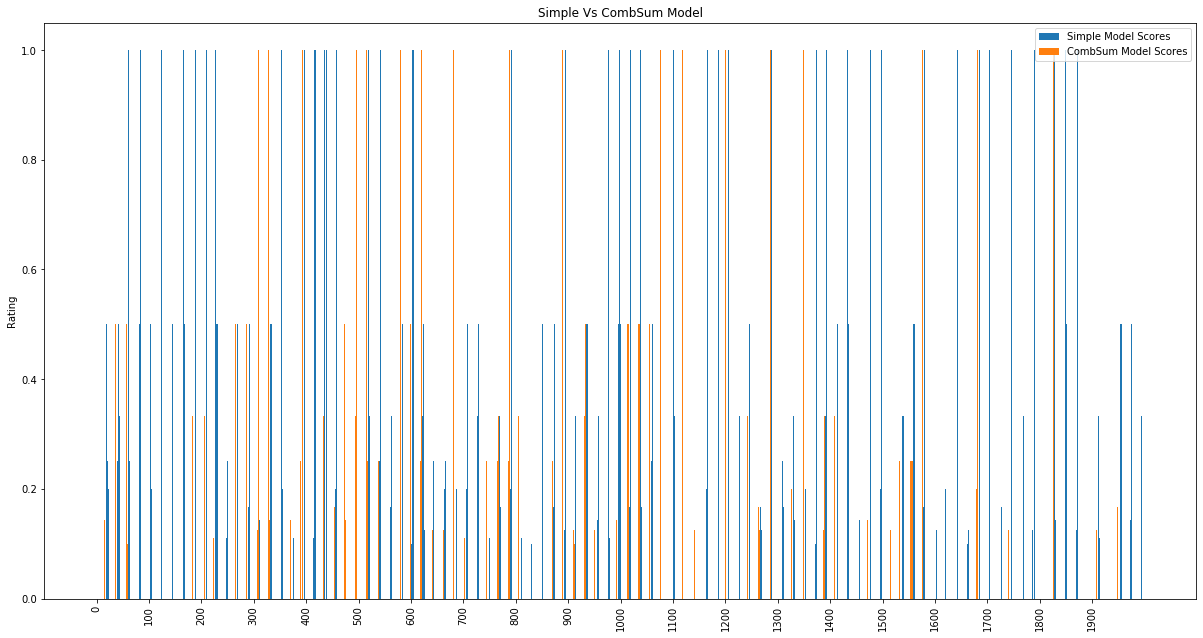

In [0]:
#Question4
import matplotlib.pyplot as plt

#Question 2 Model

combsum_dataset = np.zeros(implicit_model_q2._num_items)
for userid in uid_map.values():
  combsum_dataset += implicit_model_q2.predict(userid)

#Question 3 Model
for userid in uid_map.values():
  combsum_dataset += implicit_model_q3.predict(userid)

#combsum_dataset = (q2_dataset*0.5) + (q3_dataset*0.5)
class combSum_model:
  
  def __init__(self,combsum_dataset):
    self.predictions = combsum_dataset
  #returns an array of scores, one for each item
  def predict(self, uid):
    return(self.predictions)
combsum_model  = combSum_model(combsum_dataset)
after_scores = mrr_score(combsum_model,test_dataset)
print(after_scores.mean())

counter = 0
for i,j in zip(rrs,after_scores):
  if j>i:
    counter += 1
print("%d Users have been improved"%counter)
width = 0.2
ind = np.arange(len(uid_map.values()))
fg = plt.figure(figsize=(20, 10))
ax = fg.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(ind - width / 2, rrs, width,
       label='Simple Model Scores')
ax.bar(ind + width / 2, after_scores, width,
       label='CombSum Model Scores')

ax.set_title('Simple Vs CombSum Model')
ax.set_ylabel('Rating')
ax.set_xticklabels(np.arange(0,2000,100))
ax.legend()
plt.xticks(np.arange(0,2000,100), rotation=90)
plt.show()

# Question 5



Part of the below code , was produced based on the Lab_1's solution.

In [0]:

# pairswithcounts gives is the frequency of (X AND Y). 
#We therefore need the counts of movies
positives=ratings_df[ratings_df["rating"]>=4]
#join positives with itself on userId to get all pairs of movies watched by a given user.
pairs=pd.merge(positives, positives, on=["user_id"])
pairs = pairs.query("book_id_x != book_id_y")
#lets count the frequency of each pair of movies.
paircounts=pairs[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()

#sort by the most popular pairs.
pairswithcounts = paircounts.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)

bookCounts = positives.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})

#lets puts all the information in the sample dataframe.
allstats = pairswithcounts.merge(bookCounts, left_on="book_id_x", right_on="book_id").merge(bookCounts, left_on="book_id_y", right_on="book_id")

#and drop out some unused columns
allstats = allstats[["book_id_x",	"book_id_y",	"count", "ratingCount_x", "ratingCount_y"]]
allstats = allstats.loc[:,~allstats.columns.duplicated()]

#to calculate probabilites we need a denominator. I used the number of total ratings
num=float(ratings_df.count()["rating"])

#we can then perform artihmetic on columns
allstats["lift"] = (allstats["count"] / num ) / ( (allstats["ratingCount_x"] / num) * (allstats["ratingCount_y"] / num))

allstats = allstats.query("book_id_x != book_id_y")
allstats['loglift'] = np.log(allstats['lift'])
allstats.sort_values(['loglift'], ascending=False)

def dict_create(allstats,support_threshhold):
  temp_allstats = allstats[allstats['count']>support_threshhold]
  stats_dict = {}
  for _,row in temp_allstats.iterrows():
    stats_dict[(row['book_id_x'],row['book_id_y'])] = row['loglift']
  return stats_dict

In [0]:

class Pair_Recommender:
  
  def __init__(self, stats_dict):
    self.stats_dict = stats_dict
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, id):
    uid = uid_rev_map.get(id)
    item_scores = np.zeros(len(iid_map.keys()))
    rate_temp_user = ratings_df.loc[ratings_df['user_id']==uid] # books_id that user has read
    positive_rate_user = rate_temp_user.loc[rate_temp_user['rating']>=4]['book_id'] #books_ id that user has positevily rate
    for iid in iid_map.keys():
      if iid not in rate_temp_user['book_id']:
        for iid2 in positive_rate_user:
          if (iid,iid2) in self.stats_dict.keys():
            item_scores[iid_map.get(iid)] += self.stats_dict[(iid,iid2)]
    return item_scores

pair_recommender = Pair_Recommender(dict_create(allstats,0))
pair_score = mrr_score(pair_recommender,validation,train=rating_dataset)
print(pair_score.mean())

0.010249172205150195


0
0.010249172205150195
50
0.006400620945393331
100
0.010195375465510534
150
0.0073328330832082705
200
0.0026263131565782893


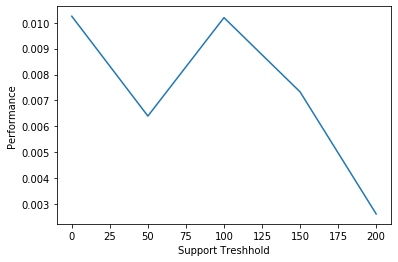

In [0]:
import time
x = []
y = []
for i in range(0,250,50):
  print(i)
  x.append(i)
  start_time = time.time()
  pair_recommender = Pair_Recommender(dict_create(allstats,i))
  pair_score = mrr_score(pair_recommender,validation,train=rating_dataset)
  mmean = pair_score.mean()
  print(mmean)
  y.append(mmean)

plt.plot(x,y)
plt.ylabel("Performance")
plt.xlabel("Support Treshhold")
plt.show()


In [0]:
temp_allstats = allstats
impli_score = mrr_score(implicit_model_q2, test_dataset,train=rating_dataset)
pair_recommender =Pair_Recommender(dict_create(allstats,0))
pair_score = mrr_score(pair_recommender,test_dataset,train=rating_dataset)
print(pair_score.mean())

0.34997141427856787


# Question 6



In [0]:
class CombSum:
  
  def __init__(self,models,weights):
    self.weights = weights
    self.models = models
  #returns an array of scores, one for each item

  def predict(self, uid):
    x = np.zeros(self.models[1]._num_items)
    for i,m in enumerate(self.models):
      x += (self.weights[i]*m.predict(uid))
    return(x)
    
weight_list =[[0.5,0.1,0.4],[0.4,0.2,0.4,],[0.33,0.33,0.33]]
for weights in weight_list:
  combSum  = CombSum([implicit_model_q2,implicit_model_q3,Pair_Recommender(dict_create(allstats,100))],weights)
  after_scores = mrr_score(combSum,validation,train=rating_dataset)
  print(after_scores.mean())



0.012717866869942907
0.012050072655375306
0.011875977671375371


In [0]:
combSum  = CombSum([implicit_model_q2,implicit_model_q3,Pair_Recommender(dict_create(allstats,100))],[0.5,0.1,0.4])
after_scores = mrr_score(combSum,test_dataset,train=rating_dataset)
print(after_scores.mean())

0.4383612441141206
